# tf cifar10 structure, fedlearn cifar10 similar structure 

In [1]:
import numpy as np
import matplotlib

from matplotlib import pyplot as plt
from matplotlib import cm as cmap

import tensorflow as tf

import keras
from keras.datasets import cifar10, mnist
from keras.utils import np_utils

import random

Using TensorFlow backend.


In [2]:


def fully_connected(input_node, num_outputs, scope=None):
    """ Implements a fully connected layer. """
    w_initializer = tf.truncated_normal_initializer(stddev=0.04)
    b_initializer = tf.constant_initializer(0.0)
    input_shape = input_node.get_shape()
    with tf.variable_scope(scope or 'fc'):
        w = tf.get_variable(name='w', shape=[input_shape[1], num_outputs], initializer=w_initializer)
        b = tf.get_variable(name='b', shape=[num_outputs], initializer=b_initializer)
    fc = tf.matmul(input_node, w) + b
    return fc, (w, b)



In [3]:


def conv_layer(input_node, num_filters, filter_sz, stride=1, scope=None):
    """ Implements a convolution layer. """
    w_initializer = tf.truncated_normal_initializer(stddev=5e-2)
    b_initializer = tf.constant_initializer(0.0)
    input_shape = input_node.get_shape()  # input_shape supposed to be [batch, h, w, d]
    with tf.variable_scope(scope or 'conv'):
        w = tf.get_variable(name='w', shape=[filter_sz, filter_sz, input_shape[-1], num_filters], initializer=w_initializer)
        b = tf.get_variable(name='b', shape=[num_filters] , initializer=b_initializer)
        conv_out = tf.nn.conv2d(input_node, w, strides=[1, stride, stride, 1], padding='SAME')
        #conv_out = conv_out + b
        conv_out = tf.nn.bias_add(conv_out, b)
    return conv_out, (w, b)



In [14]:
# (train_x, train_y), (test_x, test_y) = mnist.load_data()

(train_x, train_y), (test_x, test_y) = cifar10.load_data()

train_x = train_x.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.0
test_x = test_x.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.0
batch_size = 128

global_step = 400
init_learning_rate = 0.1
lr_decay = 0.1

reg_beta = 0.004

train_y = np_utils.to_categorical(train_y, 10)
test_y = np_utils.to_categorical(test_y, 10)

print(train_x.shape)
print(train_x.shape[0]//batch_size)

(50000, 32, 32, 3)
390


In [15]:
# reset default-graph
tf.reset_default_graph()
# with tf.Graph().as_default():

# setting random seed:
seed = 1234
np.random.seed(seed)
tf.set_random_seed(seed)
random.seed(seed)

# place-holder for mnist data
x_holder = tf.placeholder(tf.float32, [None, 32, 32, 3])
y_holder = tf.placeholder(tf.float32, [None, 10])

# network: (conv-pool-norm)-(conv-norm-pool)-fc-fc-fc
with tf.name_scope('conv1'):
    conv1, (w1, b1) = conv_layer(x_holder, 64, 5, 1, 'conv1')
    conv1 = tf.nn.relu(conv1)
    mp1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1,2, 2,1], padding='SAME')
    norm1 = tf.nn.lrn(mp1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

with tf.name_scope('conv2'):
    conv2, (w2, b2) = conv_layer(mp1, 64, 5, 1, 'conv2')
    conv2 = tf.nn.relu(conv2)
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    mp2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2,1], padding='SAME')

mp_shape = mp2.get_shape()
flat_dim = int(mp_shape[1] * mp_shape[2] * mp_shape[3])
flat_conv = tf.reshape(mp2, [-1, flat_dim])

with tf.name_scope('fc_3'):
    fc3, (w3, b3) = fully_connected(flat_conv, 384, scope='fc_3')
fc3 = tf.nn.relu(fc3)   

with tf.name_scope('fc_4'):
    fc4, (w4, b4) = fully_connected(fc3, 192, scope='fc_4')
fc4 = tf.nn.relu(fc4)   
    
with tf.name_scope('soft_max'):
    fc5, (w5, b5) = fully_connected(fc4, 10, scope='soft_max')

logits = fc5
preds = tf.nn.softmax(logits)
correct_preds = tf.equal(tf.argmax(logits, 1), tf.argmax(y_holder, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_holder,
                                            logits=logits)
)

# adding regularizer to cost function
regularizer = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3) + tf.nn.l2_loss(w4) + tf.nn.l2_loss(w5)
loss = tf.reduce_mean(loss + reg_beta * regularizer)


# # exponential decay for learning rate
# # init_learning_rate = 0.1
# # global_step = 10000
# # global_step = 10000
# learning_rate_use = tf.train.exponential_decay(init_learning_rate, 
#                                                global_step,
#                                                1, 0.3, 
#                                                staircase=True)

# change learning rate during training:
lr_holder = tf.placeholder(tf.float32, [], name='learning_rate')


# regular training (from scratch) using vanila SGD

# using momentum
# opt = tf.train.MomentumOptimizer(learning_rate,0.9)                                 
opt = tf.train.GradientDescentOptimizer(lr_holder)
train_op = opt.minimize(loss)

all_variable = tf.trainable_variables()
all_var_num = len(all_variable)
print('Number of Variables is ', len(all_variable))
print('\nAll variables')
for var in (all_variable):
    print(var)

Number of Variables is  10

All variables
<tf.Variable 'conv1/w:0' shape=(5, 5, 3, 64) dtype=float32_ref>
<tf.Variable 'conv1/b:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'conv2/w:0' shape=(5, 5, 64, 64) dtype=float32_ref>
<tf.Variable 'conv2/b:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'fc_3/w:0' shape=(4096, 384) dtype=float32_ref>
<tf.Variable 'fc_3/b:0' shape=(384,) dtype=float32_ref>
<tf.Variable 'fc_4/w:0' shape=(384, 192) dtype=float32_ref>
<tf.Variable 'fc_4/b:0' shape=(192,) dtype=float32_ref>
<tf.Variable 'soft_max/w:0' shape=(192, 10) dtype=float32_ref>
<tf.Variable 'soft_max/b:0' shape=(10,) dtype=float32_ref>


In [16]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)  # use only 50% of memory
#     self.session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

vali_cost =[]
vali_acc = []
train_cost = []

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as session:   # everything runs in this session
#     with tf.Session() as session:
    session.run(tf.global_variables_initializer())  # initialize all variables(trainable weights)
    
    
    
    for k in range(global_step):                             # train for xx epochs
        
        if k<100:
            learning_rate = init_learning_rate*(lr_decay**0)
        elif k<200:
            learning_rate = init_learning_rate*(lr_decay**1)
        else:
            learning_rate = init_learning_rate*(lr_decay**2)
            
        train_cost_i = 0
        
        for i in range(train_x.shape[0]//batch_size):  # iterate for trainNO/batchSize times(not necessarily visit every sample once)
            batch_idx = np.random.choice(train_x.shape[0], batch_size, replace=False)  # select batch_size from train_num (no-replacement: no repetitive)
            batch_xs = train_x[batch_idx]
            batch_ys = train_y[batch_idx]
            _, cost_val, acc_val = session.run([train_op, loss, accuracy], feed_dict = {x_holder: batch_xs,
                                                            y_holder: batch_ys,
                                                            lr_holder: learning_rate
                                                            })
            train_cost_i = train_cost_i + cost_val
            
        train_cost_i /= (i+1)
            
            
        vali_cost_i, vali_acc_i = session.run([loss, accuracy], feed_dict = {x_holder: test_x, y_holder: test_y})
        print('No:%3d  Train_loss:%.3e  Cost:%.3e  Acc:%.2f    LR:%.3f'  %(k, train_cost_i, vali_cost_i, vali_acc_i, learning_rate))
        train_cost.append(train_cost_i)
        vali_cost.append(vali_cost_i)
        vali_acc.append(vali_acc_i)

No:  0  Train_loss:8.729e+00  Cost:6.717e+00  Acc:0.34    LR:0.100
No:  1  Train_loss:5.292e+00  Cost:4.170e+00  Acc:0.49    LR:0.100
No:  2  Train_loss:3.496e+00  Cost:2.913e+00  Acc:0.52    LR:0.100
No:  3  Train_loss:2.539e+00  Cost:2.258e+00  Acc:0.56    LR:0.100
No:  4  Train_loss:2.006e+00  Cost:1.785e+00  Acc:0.62    LR:0.100
No:  5  Train_loss:1.733e+00  Cost:1.656e+00  Acc:0.60    LR:0.100
No:  6  Train_loss:1.553e+00  Cost:1.508e+00  Acc:0.64    LR:0.100
No:  7  Train_loss:1.456e+00  Cost:1.475e+00  Acc:0.64    LR:0.100
No:  8  Train_loss:1.395e+00  Cost:1.423e+00  Acc:0.66    LR:0.100
No:  9  Train_loss:1.380e+00  Cost:1.906e+00  Acc:0.48    LR:0.100
No: 10  Train_loss:1.336e+00  Cost:1.424e+00  Acc:0.66    LR:0.100
No: 11  Train_loss:1.325e+00  Cost:1.511e+00  Acc:0.63    LR:0.100
No: 12  Train_loss:1.309e+00  Cost:1.657e+00  Acc:0.60    LR:0.100
No: 13  Train_loss:1.306e+00  Cost:1.407e+00  Acc:0.68    LR:0.100
No: 14  Train_loss:1.303e+00  Cost:1.341e+00  Acc:0.71    LR:0

No:123  Train_loss:8.150e-01  Cost:1.264e+00  Acc:0.78    LR:0.010
No:124  Train_loss:8.132e-01  Cost:1.254e+00  Acc:0.78    LR:0.010
No:125  Train_loss:8.129e-01  Cost:1.276e+00  Acc:0.77    LR:0.010
No:126  Train_loss:8.112e-01  Cost:1.253e+00  Acc:0.78    LR:0.010
No:127  Train_loss:8.058e-01  Cost:1.273e+00  Acc:0.78    LR:0.010
No:128  Train_loss:8.052e-01  Cost:1.266e+00  Acc:0.78    LR:0.010
No:129  Train_loss:8.057e-01  Cost:1.261e+00  Acc:0.78    LR:0.010
No:130  Train_loss:8.034e-01  Cost:1.270e+00  Acc:0.78    LR:0.010
No:131  Train_loss:8.005e-01  Cost:1.274e+00  Acc:0.77    LR:0.010
No:132  Train_loss:7.993e-01  Cost:1.274e+00  Acc:0.78    LR:0.010
No:133  Train_loss:8.018e-01  Cost:1.273e+00  Acc:0.78    LR:0.010
No:134  Train_loss:8.000e-01  Cost:1.304e+00  Acc:0.76    LR:0.010
No:135  Train_loss:7.966e-01  Cost:1.273e+00  Acc:0.78    LR:0.010
No:136  Train_loss:7.976e-01  Cost:1.289e+00  Acc:0.78    LR:0.010
No:137  Train_loss:7.942e-01  Cost:1.274e+00  Acc:0.78    LR:0

No:246  Train_loss:7.112e-01  Cost:1.290e+00  Acc:0.77    LR:0.001
No:247  Train_loss:7.137e-01  Cost:1.291e+00  Acc:0.77    LR:0.001
No:248  Train_loss:7.120e-01  Cost:1.289e+00  Acc:0.78    LR:0.001
No:249  Train_loss:7.106e-01  Cost:1.290e+00  Acc:0.77    LR:0.001
No:250  Train_loss:7.117e-01  Cost:1.289e+00  Acc:0.78    LR:0.001
No:251  Train_loss:7.103e-01  Cost:1.289e+00  Acc:0.78    LR:0.001
No:252  Train_loss:7.105e-01  Cost:1.288e+00  Acc:0.78    LR:0.001
No:253  Train_loss:7.117e-01  Cost:1.289e+00  Acc:0.78    LR:0.001
No:254  Train_loss:7.102e-01  Cost:1.287e+00  Acc:0.77    LR:0.001
No:255  Train_loss:7.112e-01  Cost:1.289e+00  Acc:0.77    LR:0.001
No:256  Train_loss:7.096e-01  Cost:1.289e+00  Acc:0.78    LR:0.001
No:257  Train_loss:7.108e-01  Cost:1.290e+00  Acc:0.77    LR:0.001
No:258  Train_loss:7.101e-01  Cost:1.289e+00  Acc:0.77    LR:0.001
No:259  Train_loss:7.096e-01  Cost:1.288e+00  Acc:0.78    LR:0.001
No:260  Train_loss:7.084e-01  Cost:1.289e+00  Acc:0.77    LR:0

No:369  Train_loss:6.972e-01  Cost:1.292e+00  Acc:0.77    LR:0.001
No:370  Train_loss:6.961e-01  Cost:1.292e+00  Acc:0.77    LR:0.001
No:371  Train_loss:6.970e-01  Cost:1.293e+00  Acc:0.77    LR:0.001
No:372  Train_loss:6.972e-01  Cost:1.295e+00  Acc:0.77    LR:0.001
No:373  Train_loss:6.971e-01  Cost:1.292e+00  Acc:0.77    LR:0.001
No:374  Train_loss:6.971e-01  Cost:1.290e+00  Acc:0.77    LR:0.001
No:375  Train_loss:6.970e-01  Cost:1.293e+00  Acc:0.77    LR:0.001
No:376  Train_loss:6.969e-01  Cost:1.292e+00  Acc:0.77    LR:0.001
No:377  Train_loss:6.956e-01  Cost:1.292e+00  Acc:0.77    LR:0.001
No:378  Train_loss:6.951e-01  Cost:1.295e+00  Acc:0.77    LR:0.001
No:379  Train_loss:6.957e-01  Cost:1.294e+00  Acc:0.77    LR:0.001
No:380  Train_loss:6.946e-01  Cost:1.292e+00  Acc:0.77    LR:0.001
No:381  Train_loss:6.951e-01  Cost:1.294e+00  Acc:0.77    LR:0.001
No:382  Train_loss:6.965e-01  Cost:1.292e+00  Acc:0.77    LR:0.001
No:383  Train_loss:6.956e-01  Cost:1.292e+00  Acc:0.77    LR:0

In [20]:
def plot_LearningCurve(vali_cost, vali_acc):
    width = 12
    height = 9
    fig= plt.figure(figsize=(width, height))
    ax = fig.add_subplot(1,1,1) #add_subplot(1,1,1)
    
    data_length=len(vali_cost)

    plt.plot(np.arange(data_length), vali_cost, 'b-.', markersize=1,label= 'Validation Cost')
    plt.plot(np.arange(data_length), (1-np.array([vali_acc])).reshape([data_length,]), 'r-', markersize=3, label= 'Validation Error-rate')

    ax.grid()
    ax.legend()
    plt.xlabel('Num of Epochs')
    plt.ylabel('Validation Accuracy and Cost')
    plt.show()

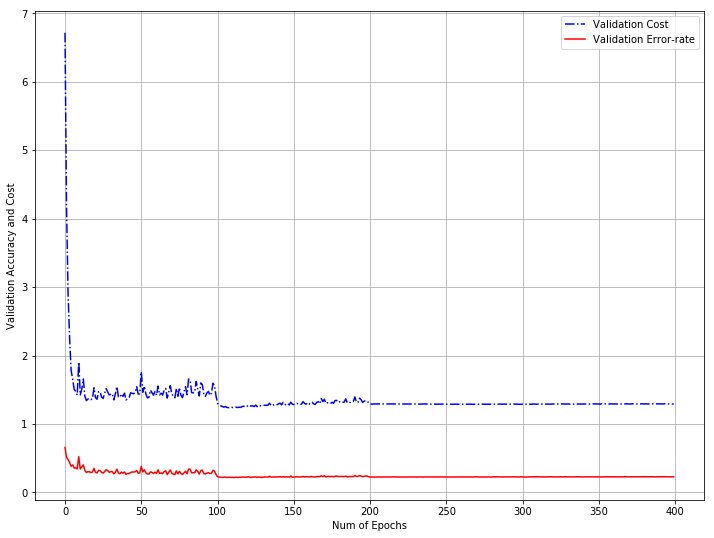

In [21]:
plot_LearningCurve(vali_cost, vali_acc)